URL del dataset:

https://www.kaggle.com/christianlillelund/csgo-round-winner-classification
    

Aclaracion: Cada una de las observaciones del dataset, describe el estado de una ronda y por lo tanto pueden tratarse individualmente. Aunque se pueden haber tomado distintas observaciones que pertenecen a la misma ronda.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

from sklearn.pipeline import Pipeline, make_union, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, accuracy_score

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier 


pd.set_option('display.max_columns', 500)

%matplotlib inline

In [3]:
# Importamos los datos

data = pd.read_csv('Data/cs_go_grupo5.csv', index_col='Unnamed: 0')

df = data.copy()

In [4]:
df.head()

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


# EXPLORATORY DATA ANALYSIS (EDA)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121054 entries, 0 to 122409
Data columns (total 97 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   time_left                     121054 non-null  float64
 1   ct_score                      121054 non-null  float64
 2   t_score                       121054 non-null  float64
 3   map                           121054 non-null  object 
 4   bomb_planted                  121054 non-null  bool   
 5   ct_health                     121054 non-null  float64
 6   t_health                      121054 non-null  float64
 7   ct_armor                      121054 non-null  float64
 8   t_armor                       121054 non-null  float64
 9   ct_money                      121054 non-null  float64
 10  t_money                       121054 non-null  float64
 11  ct_helmets                    121054 non-null  float64
 12  t_helmets                     121054 non-nul

In [6]:
# Chequeamos si hay datos faltantes

df.isnull().any().any()

False

In [7]:
df.describe()

,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
count,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.0,121054.000000,121054.000000,121054.000000,121054.00000,121054.000000,121054.000000,121054.000000,121054.0,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.0,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.00000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.0,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.0,121054.000000,121054.0,121054.00000,121054.000000,121054.0,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000,121054.000000
mean,97.779809,6.697152,6.768888,412.612892,403.256034,316.213632,300.425488,9835.801378,11299.019446,2.065822,2.790845,1.621863,4.278677,4.271482,0.275356,1.251442,0.135320,0.007592,0.576420,0.322154,0.0,0.000083,0.152618,0.106308,0.00399,0.001727,0.110835,0.004725,0.0,0.000801,0.011136,0.111017,0.006386,3.313620,0.000008,0.0,0.064203,0.002718,1.082872,0.052216,0.007625,0.108224,0.004436,0.00005,0.001479,0.002784,0.002057,0.001974,0.148182,0.005675,0.0,0.000008,0.000991,0.000107,0.000165,0.000157,0.0,0.000058,0.0,0.00014,0.000710,0.0,0.239604,0.829076,0.060023,0.020611,0.046797,0.036736,0.007592,0.000264,0.441811,0.381590,0.061741,0.009326,3.182869,0.122747,0.237134,0.291911,0.174203,0.004981,0.008129,0.028194,0.906381,0.441200,1.865399,1.871330,1.552745,1.640747,1.010590,0.019462,0.047805,1.363846,0.027872,0.025914
std,54.274380,4.791150,4.824726,131.805923,139.401569,170.006382,173.772098,11223.205878,12175.515454,1.841998,2.008555,1.606205,1.200535,1.223086,0.585206,1.365961,0.461609,0.091163,0.673945,0.476927,0.0,0.009089,0.446796,0.380639,0.06304,0.041515,0.390294,0.070713,0.0,0.037356,0.112607,0.407292,0.083106,1.621623,0.002874,0.0,0.263595,0.053005,1.221081,0.245619,0.094628,0.413512,0.067688,0.0

Vamos a querer preprocesar los datos de la siguiente manera:
 - Transformer para Dummies, para la columna `map`
 - Transformar a int, para la columna `bomb_planted`

Pero ANTES QUE NADA, genero el dataset X, el target y, y divido mis datos en train y test

In [8]:
X =  df.drop(columns = 'round_winner')
y = df.round_winner

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 12)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(90790, 96) (90790,) (30264, 96) (30264,)


In [10]:
display(X_train[:5], y_train[:5])

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
7621,94.95,15.0,7.0,de_inferno,False,500.0,500.0,300.0,456.0,7000.0,15450.0,1.0,5.0,0.0,5.0,5.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0
121114,74.96,1.0,5.0,de_nuke,False,300.0,389.0,300.0,436.0,400.0,15800.0,2.0,5.0,0.0,3.0,5.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,0.0
10710,175.00,6.0,6.0,de_vertigo,False,500.0,500.0,500.0,100.0,5300.0,16000.0,5.0,0.0,4.0,5.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0
6092,34.91,4.0,5.0,de_vertigo,False,256.0,300.0,296.0,200.0,13200.0,750.0,3.0,2.0,3.0,3.0,3.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
105793,174.96,3.0,14.0,de_mirage,False,500.0,500.0,0.0,184.0,13350.0,19100.0,0.0,2.0,0.0,5.0,5.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


7621       T
121114    CT
10710     CT
6092       T
105793     T
Name: round_winner, dtype: object

Ahora armo los trasformers, pipelines etc

In [11]:
X.map.head(2)

0    de_dust2
1    de_dust2
Name: map, dtype: object

In [12]:
pd.get_dummies(X, columns = ['map'], drop_first = True )

,time_left,ct_score,t_score,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,map_de_dust2,map_de_inferno,map_de_mirage,map_de_nuke,map_de_overpass,map_de_train,map_de_vertigo
0,175.00,0.0,0.0,False,500.0,500.0,0.0,0.0,4000.0,4000.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
1,156.03,0.0,0.0,False,500.0,500.0,400.0,300.0,600.0,650.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
2,96.03,0.0,0.0,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
3,76.03,0.0,0.0,False,391.0,400.0,294.0,200.0,750.0,500.0,0.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
4,174.97,1.0,0.0,False,500.0,500.0,192.0,0.0,18350.0,10750.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [13]:
class MakeDummies(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X1 = pd.get_dummies(X, columns = self.columns, drop_first = True)
        self.feature_names = X1.columns.tolist()
        return X1
    
    def get_feature_names(self):
        return self.feature_names
            
    
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.features = features
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X1 = pd.DataFrame(X[self.features])
        self.feature_names = X1.columns.tolist()
        return pd.DataFrame(X[self.features])
    
    def get_feature_names(self):
        return self.feature_names
      
    
class MakeInt(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X1 = pd.DataFrame(X[self.columns].astype(int))
        self.feature_names = X1.columns.tolist()
        return pd.DataFrame(X[self.columns].astype(int))
    
    def get_feature_names(self):
        return self.feature_names
    
    

 - Dummies pipe

In [14]:
dummies_pipe = make_pipeline(FeatureSelector(['map']),
                             MakeDummies(['map']))

dummies_pipe.fit_transform(X).sample(5)

,map_de_dust2,map_de_inferno,map_de_mirage,map_de_nuke,map_de_overpass,map_de_train,map_de_vertigo
92780,0,0,0,0,0,1,0
62836,0,0,0,0,0,1,0
33042,0,0,0,0,1,0,0
116680,1,0,0,0,0,0,0
87655,0,0,1,0,0,0,0


In [15]:
dummies_pipe.named_steps['makedummies']

MakeDummies(columns=['map'])

In [16]:
dummies_pipe[1].get_feature_names()

['map_de_dust2',
 'map_de_inferno',
 'map_de_mirage',
 'map_de_nuke',
 'map_de_overpass',
 'map_de_train',
 'map_de_vertigo']

In [17]:
dummies_pipe[-1:][0]

MakeDummies(columns=['map'])

In [18]:
dummies_pipe[-1:][0].get_feature_names()

['map_de_dust2',
 'map_de_inferno',
 'map_de_mirage',
 'map_de_nuke',
 'map_de_overpass',
 'map_de_train',
 'map_de_vertigo']

 - Int_pipe

In [19]:
int_pipe = make_pipeline(FeatureSelector(['bomb_planted']),
                        MakeInt(['bomb_planted']))

int_pipe.fit_transform(X).sample(5)

,bomb_planted
67965,0
16905,0
601,0
74340,1
16319,0


In [20]:
int_pipe

Pipeline(steps=[('featureselector', FeatureSelector(features=['bomb_planted'])),
                ('makeint', MakeInt(columns=['bomb_planted']))])

In [21]:
int_pipe[-1:][0].get_feature_names()

['bomb_planted']

 - Resto de las columnas

In [22]:
resto_columnas = list(X.drop(columns = ['map', 'bomb_planted'], axis =1).columns)
#resto_columnas
resto_columnas_pipe = make_pipeline(FeatureSelector(resto_columnas))

resto_columnas_pipe.fit_transform(X).sample(5)

,time_left,ct_score,t_score,ct_health,t_health,ct_armor,t_armor,ct_money,t_money,ct_helmets,t_helmets,ct_defuse_kits,ct_players_alive,t_players_alive,ct_weapon_ak47,t_weapon_ak47,ct_weapon_aug,t_weapon_aug,ct_weapon_awp,t_weapon_awp,ct_weapon_bizon,t_weapon_bizon,ct_weapon_cz75auto,t_weapon_cz75auto,ct_weapon_elite,t_weapon_elite,ct_weapon_famas,t_weapon_famas,ct_weapon_g3sg1,t_weapon_g3sg1,ct_weapon_galilar,t_weapon_galilar,ct_weapon_glock,t_weapon_glock,ct_weapon_m249,t_weapon_m249,ct_weapon_m4a1s,t_weapon_m4a1s,ct_weapon_m4a4,t_weapon_m4a4,ct_weapon_mac10,t_weapon_mac10,ct_weapon_mag7,t_weapon_mag7,ct_weapon_mp5sd,t_weapon_mp5sd,ct_weapon_mp7,t_weapon_mp7,ct_weapon_mp9,t_weapon_mp9,ct_weapon_negev,t_weapon_negev,ct_weapon_nova,t_weapon_nova,ct_weapon_p90,t_weapon_p90,ct_weapon_r8revolver,t_weapon_r8revolver,ct_weapon_sawedoff,t_weapon_sawedoff,ct_weapon_scar20,t_weapon_scar20,ct_weapon_sg553,t_weapon_sg553,ct_weapon_ssg08,t_weapon_ssg08,ct_weapon_ump45,t_weapon_ump45,ct_weapon_xm1014,t_weapon_xm1014,ct_weapon_deagle,t_weapon_deagle,ct_weapon_fiveseven,t_weapon_fiveseven,ct_weapon_usps,t_weapon_usps,ct_weapon_p250,t_weapon_p250,ct_weapon_p2000,t_weapon_p2000,ct_weapon_tec9,t_weapon_tec9,ct_grenade_hegrenade,t_grenade_hegrenade,ct_grenade_flashbang,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade
92499,175.00,7.0,8.0,500.0,500.0,100.0,100.0,1050.0,1850.0,0.0,0.0,1.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
89324,175.00,4.0,11.0,500.0,500.0,0.0,100.0,4000.0,1150.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
74245,9.13,8.0,11.0,398.0,385.0,400.0,473.0,750.0,14400.0,1.0,5.0,1.0,4.0,5.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
69376,97.52,13.0,12.0,453.0,500.0,474.0,499.0,2550.0,4000.0,3.0,5.0,2.0,5.0,5.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,4.0,4.0,3.0,5.0,2.0,0.0,0.0,4.0,0.0,0.0
96807,94.95,2.0,0.0,500.0,475.0,442.0,492.0,14900.0,300.0,4.0,5.0,2.0,5.0,5.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,4.0,4.0,3.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0


In [23]:
resto_columnas_pipe

Pipeline(steps=[('featureselector',
                 FeatureSelector(features=['time_left', 'ct_score', 't_score',
                                           'ct_health', 't_health', 'ct_armor',
                                           't_armor', 'ct_money', 't_money',
                                           'ct_helmets', 't_helmets',
                                           'ct_defuse_kits', 'ct_players_alive',
                                           't_players_alive', 'ct_weapon_ak47',
                                           't_weapon_ak47', 'ct_weapon_aug',
                                           't_weapon_aug', 'ct_weapon_awp',
                                           't_weapon_awp', 'ct_weapon_bizon',
                                           't_weapon_bizon',
                                           'ct_weapon_cz75auto',
                                           't_weapon_cz75auto',
                                           'ct_weapon_elite', 't_weapon_elit

In [24]:
resto_columnas_pipe[-1:][0]

FeatureSelector(features=['time_left', 'ct_score', 't_score', 'ct_health',
                          't_health', 'ct_armor', 't_armor', 'ct_money',
                          't_money', 'ct_helmets', 't_helmets',
                          'ct_defuse_kits', 'ct_players_alive',
                          't_players_alive', 'ct_weapon_ak47', 't_weapon_ak47',
                          'ct_weapon_aug', 't_weapon_aug', 'ct_weapon_awp',
                          't_weapon_awp', 'ct_weapon_bizon', 't_weapon_bizon',
                          'ct_weapon_cz75auto', 't_weapon_cz75auto',
                          'ct_weapon_elite', 't_weapon_elite',
                          'ct_weapon_famas', 't_weapon_famas',
                          'ct_weapon_g3sg1', 't_weapon_g3sg1', ...])

In [25]:
resto_columnas_pipe[-1:][0].get_feature_names()

['time_left',
 'ct_score',
 't_score',
 'ct_health',
 't_health',
 'ct_armor',
 't_armor',
 'ct_money',
 't_money',
 'ct_helmets',
 't_helmets',
 'ct_defuse_kits',
 'ct_players_alive',
 't_players_alive',
 'ct_weapon_ak47',
 't_weapon_ak47',
 'ct_weapon_aug',
 't_weapon_aug',
 'ct_weapon_awp',
 't_weapon_awp',
 'ct_weapon_bizon',
 't_weapon_bizon',
 'ct_weapon_cz75auto',
 't_weapon_cz75auto',
 'ct_weapon_elite',
 't_weapon_elite',
 'ct_weapon_famas',
 't_weapon_famas',
 'ct_weapon_g3sg1',
 't_weapon_g3sg1',
 'ct_weapon_galilar',
 't_weapon_galilar',
 'ct_weapon_glock',
 't_weapon_glock',
 'ct_weapon_m249',
 't_weapon_m249',
 'ct_weapon_m4a1s',
 't_weapon_m4a1s',
 'ct_weapon_m4a4',
 't_weapon_m4a4',
 'ct_weapon_mac10',
 't_weapon_mac10',
 'ct_weapon_mag7',
 't_weapon_mag7',
 'ct_weapon_mp5sd',
 't_weapon_mp5sd',
 'ct_weapon_mp7',
 't_weapon_mp7',
 'ct_weapon_mp9',
 't_weapon_mp9',
 'ct_weapon_negev',
 't_weapon_negev',
 'ct_weapon_nova',
 't_weapon_nova',
 'ct_weapon_p90',
 't_weapon_p9

 - Union

In [26]:
union = make_union(resto_columnas_pipe,
                  int_pipe,
                  dummies_pipe)

 - Aplico la union de transformaciones a X_train

In [27]:
union.fit_transform(X_train)

array([[ 94.95,  15.  ,   7.  , ...,   0.  ,   0.  ,   0.  ],
       [ 74.96,   1.  ,   5.  , ...,   0.  ,   0.  ,   0.  ],
       [175.  ,   6.  ,   6.  , ...,   0.  ,   0.  ,   1.  ],
       ...,
       [175.  ,   0.  ,   0.  , ...,   0.  ,   0.  ,   0.  ],
       [175.  ,  10.  ,   5.  , ...,   0.  ,   1.  ,   0.  ],
       [ 94.95,   8.  ,  14.  , ...,   0.  ,   0.  ,   0.  ]])

In [28]:
union.transformer_list

[('pipeline-1',
  Pipeline(steps=[('featureselector',
                   FeatureSelector(features=['time_left', 'ct_score', 't_score',
                                             'ct_health', 't_health', 'ct_armor',
                                             't_armor', 'ct_money', 't_money',
                                             'ct_helmets', 't_helmets',
                                             'ct_defuse_kits', 'ct_players_alive',
                                             't_players_alive', 'ct_weapon_ak47',
                                             't_weapon_ak47', 'ct_weapon_aug',
                                             't_weapon_aug', 'ct_weapon_awp',
                                             't_weapon_awp', 'ct_weapon_bizon',
                                             't_weapon_bizon',
                                             'ct_weapon_cz75auto',
                                             't_weapon_cz75auto',
                                  

In [48]:
union.transformer_list[0][1][0]

FeatureSelector(features=['time_left', 'ct_score', 't_score', 'ct_health',
                          't_health', 'ct_armor', 't_armor', 'ct_money',
                          't_money', 'ct_helmets', 't_helmets',
                          'ct_defuse_kits', 'ct_players_alive',
                          't_players_alive', 'ct_weapon_ak47', 't_weapon_ak47',
                          'ct_weapon_aug', 't_weapon_aug', 'ct_weapon_awp',
                          't_weapon_awp', 'ct_weapon_bizon', 't_weapon_bizon',
                          'ct_weapon_cz75auto', 't_weapon_cz75auto',
                          'ct_weapon_elite', 't_weapon_elite',
                          'ct_weapon_famas', 't_weapon_famas',
                          'ct_weapon_g3sg1', 't_weapon_g3sg1', ...])

In [30]:
union.transformer_list[0][1][0].get_feature_names()

['time_left',
 'ct_score',
 't_score',
 'ct_health',
 't_health',
 'ct_armor',
 't_armor',
 'ct_money',
 't_money',
 'ct_helmets',
 't_helmets',
 'ct_defuse_kits',
 'ct_players_alive',
 't_players_alive',
 'ct_weapon_ak47',
 't_weapon_ak47',
 'ct_weapon_aug',
 't_weapon_aug',
 'ct_weapon_awp',
 't_weapon_awp',
 'ct_weapon_bizon',
 't_weapon_bizon',
 'ct_weapon_cz75auto',
 't_weapon_cz75auto',
 'ct_weapon_elite',
 't_weapon_elite',
 'ct_weapon_famas',
 't_weapon_famas',
 'ct_weapon_g3sg1',
 't_weapon_g3sg1',
 'ct_weapon_galilar',
 't_weapon_galilar',
 'ct_weapon_glock',
 't_weapon_glock',
 'ct_weapon_m249',
 't_weapon_m249',
 'ct_weapon_m4a1s',
 't_weapon_m4a1s',
 'ct_weapon_m4a4',
 't_weapon_m4a4',
 'ct_weapon_mac10',
 't_weapon_mac10',
 'ct_weapon_mag7',
 't_weapon_mag7',
 'ct_weapon_mp5sd',
 't_weapon_mp5sd',
 'ct_weapon_mp7',
 't_weapon_mp7',
 'ct_weapon_mp9',
 't_weapon_mp9',
 'ct_weapon_negev',
 't_weapon_negev',
 'ct_weapon_nova',
 't_weapon_nova',
 'ct_weapon_p90',
 't_weapon_p9

In [56]:
union.transformer_list[2][-1][-1].get_feature_names()

['map_de_dust2',
 'map_de_inferno',
 'map_de_mirage',
 'map_de_nuke',
 'map_de_overpass',
 'map_de_train',
 'map_de_vertigo']

In [57]:
union.transformer_list[1][-1][-1].get_feature_names()

['bomb_planted']

In [58]:
union.transformer_list[0][-1][-1].get_feature_names()

['time_left',
 'ct_score',
 't_score',
 'ct_health',
 't_health',
 'ct_armor',
 't_armor',
 'ct_money',
 't_money',
 'ct_helmets',
 't_helmets',
 'ct_defuse_kits',
 'ct_players_alive',
 't_players_alive',
 'ct_weapon_ak47',
 't_weapon_ak47',
 'ct_weapon_aug',
 't_weapon_aug',
 'ct_weapon_awp',
 't_weapon_awp',
 'ct_weapon_bizon',
 't_weapon_bizon',
 'ct_weapon_cz75auto',
 't_weapon_cz75auto',
 'ct_weapon_elite',
 't_weapon_elite',
 'ct_weapon_famas',
 't_weapon_famas',
 'ct_weapon_g3sg1',
 't_weapon_g3sg1',
 'ct_weapon_galilar',
 't_weapon_galilar',
 'ct_weapon_glock',
 't_weapon_glock',
 'ct_weapon_m249',
 't_weapon_m249',
 'ct_weapon_m4a1s',
 't_weapon_m4a1s',
 'ct_weapon_m4a4',
 't_weapon_m4a4',
 'ct_weapon_mac10',
 't_weapon_mac10',
 'ct_weapon_mag7',
 't_weapon_mag7',
 'ct_weapon_mp5sd',
 't_weapon_mp5sd',
 'ct_weapon_mp7',
 't_weapon_mp7',
 'ct_weapon_mp9',
 't_weapon_mp9',
 'ct_weapon_negev',
 't_weapon_negev',
 'ct_weapon_nova',
 't_weapon_nova',
 'ct_weapon_p90',
 't_weapon_p9

 - Así obtengo los nombres de los features finales (a partir de que incluí get_feature_names() cuando definí el tranformador

In [50]:
columnas = []
for i in range (len(union.transformer_list)):
    list = union.transformer_list[i][-1][-1].get_feature_names()
    for element in list:
        columnas.append(element)

print((columnas))    
    

['time_left', 'ct_score', 't_score', 'ct_health', 't_health', 'ct_armor', 't_armor', 'ct_money', 't_money', 'ct_helmets', 't_helmets', 'ct_defuse_kits', 'ct_players_alive', 't_players_alive', 'ct_weapon_ak47', 't_weapon_ak47', 'ct_weapon_aug', 't_weapon_aug', 'ct_weapon_awp', 't_weapon_awp', 'ct_weapon_bizon', 't_weapon_bizon', 'ct_weapon_cz75auto', 't_weapon_cz75auto', 'ct_weapon_elite', 't_weapon_elite', 'ct_weapon_famas', 't_weapon_famas', 'ct_weapon_g3sg1', 't_weapon_g3sg1', 'ct_weapon_galilar', 't_weapon_galilar', 'ct_weapon_glock', 't_weapon_glock', 'ct_weapon_m249', 't_weapon_m249', 'ct_weapon_m4a1s', 't_weapon_m4a1s', 'ct_weapon_m4a4', 't_weapon_m4a4', 'ct_weapon_mac10', 't_weapon_mac10', 'ct_weapon_mag7', 't_weapon_mag7', 'ct_weapon_mp5sd', 't_weapon_mp5sd', 'ct_weapon_mp7', 't_weapon_mp7', 'ct_weapon_mp9', 't_weapon_mp9', 'ct_weapon_negev', 't_weapon_negev', 'ct_weapon_nova', 't_weapon_nova', 'ct_weapon_p90', 't_weapon_p90', 'ct_weapon_r8revolver', 't_weapon_r8revolver', 'ct_

In [32]:
union.transformer_list

[('pipeline-1',
  Pipeline(steps=[('featureselector',
                   FeatureSelector(features=['time_left', 'ct_score', 't_score',
                                             'ct_health', 't_health', 'ct_armor',
                                             't_armor', 'ct_money', 't_money',
                                             'ct_helmets', 't_helmets',
                                             'ct_defuse_kits', 'ct_players_alive',
                                             't_players_alive', 'ct_weapon_ak47',
                                             't_weapon_ak47', 'ct_weapon_aug',
                                             't_weapon_aug', 'ct_weapon_awp',
                                             't_weapon_awp', 'ct_weapon_bizon',
                                             't_weapon_bizon',
                                             'ct_weapon_cz75auto',
                                             't_weapon_cz75auto',
                                  

In [33]:
steps_modelo = [('feature_eng', union),
                ('estandarizacion', StandardScaler()),
                ('estimador', CatBoostClassifier())]

In [34]:
pipe_modelo = Pipeline(steps_modelo)

In [35]:
pipe_modelo.fit(X_train, y_train)

Learning rate set to 0.070634
0:	learn: 0.6629789	total: 76.6ms	remaining: 1m 16s
1:	learn: 0.6355467	total: 88.9ms	remaining: 44.3s
2:	learn: 0.6125116	total: 101ms	remaining: 33.5s
3:	learn: 0.5945816	total: 113ms	remaining: 28.1s
4:	learn: 0.5765767	total: 124ms	remaining: 24.6s
5:	learn: 0.5625957	total: 137ms	remaining: 22.6s
6:	learn: 0.5511285	total: 150ms	remaining: 21.3s
7:	learn: 0.5403431	total: 163ms	remaining: 20.2s
8:	learn: 0.5310060	total: 179ms	remaining: 19.7s
9:	learn: 0.5246733	total: 194ms	remaining: 19.3s
10:	learn: 0.5180219	total: 211ms	remaining: 18.9s
11:	learn: 0.5118923	total: 224ms	remaining: 18.5s
12:	learn: 0.5066636	total: 238ms	remaining: 18s
13:	learn: 0.5018523	total: 250ms	remaining: 17.6s
14:	learn: 0.4970983	total: 261ms	remaining: 17.1s
15:	learn: 0.4926165	total: 273ms	remaining: 16.8s
16:	learn: 0.4890872	total: 285ms	remaining: 16.5s
17:	learn: 0.4864569	total: 297ms	remaining: 16.2s
18:	learn: 0.4839180	total: 309ms	remaining: 16s
19:	learn: 0

Pipeline(steps=[('feature_eng',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('featureselector',
                                                                  FeatureSelector(features=['time_left',
                                                                                            'ct_score',
                                                                                            't_score',
                                                                                            'ct_health',
                                                                                            't_health',
                                                                                            'ct_armor',
                                                                                            't_armor',
                                                                                            

In [36]:
# Accuracy del modelo, sin usar gridsearch

accuracy_score(y_test, pipe_modelo.predict(X_test))

0.8159199048374306

In [37]:
# Ahora vamos a utilizar GridSearch para tunear nuestro modelo

param_grid = [{'estandarizacion':[StandardScaler(), MinMaxScaler()],
               'estimador__learning_rate':[0.2], #[np.linspace(0.01,0.3,5)]
               'estimador__n_estimators':[4000] #[np.linspace(3000,4000,2)]
               }]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1203)

gs = GridSearchCV(pipe_modelo, param_grid, n_jobs=-1, cv= skf)

In [38]:
gs.fit(X_train, y_train)

0:	learn: 0.6163902	total: 15.3ms	remaining: 1m 1s
1:	learn: 0.5651147	total: 32ms	remaining: 1m 3s
2:	learn: 0.5299338	total: 44.1ms	remaining: 58.7s
3:	learn: 0.5128064	total: 57.9ms	remaining: 57.9s
4:	learn: 0.4989893	total: 70ms	remaining: 55.9s
5:	learn: 0.4888289	total: 83.8ms	remaining: 55.8s
6:	learn: 0.4811787	total: 96ms	remaining: 54.7s
7:	learn: 0.4774329	total: 109ms	remaining: 54.6s
8:	learn: 0.4724653	total: 121ms	remaining: 53.8s
9:	learn: 0.4680741	total: 137ms	remaining: 54.6s
10:	learn: 0.4647508	total: 151ms	remaining: 54.6s
11:	learn: 0.4616684	total: 162ms	remaining: 53.8s
12:	learn: 0.4596211	total: 174ms	remaining: 53.5s
13:	learn: 0.4579304	total: 186ms	remaining: 52.8s
14:	learn: 0.4562637	total: 196ms	remaining: 52.1s
15:	learn: 0.4548753	total: 207ms	remaining: 51.5s
16:	learn: 0.4540024	total: 225ms	remaining: 52.6s
17:	learn: 0.4525806	total: 235ms	remaining: 52.1s
18:	learn: 0.4514649	total: 244ms	remaining: 51.2s
19:	learn: 0.4504022	total: 256ms	remain

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1203, shuffle=True),
             estimator=Pipeline(steps=[('feature_eng',
                                        FeatureUnion(transformer_list=[('pipeline-1',
                                                                        Pipeline(steps=[('featureselector',
                                                                                         FeatureSelector(features=['time_left',
                                                                                                                   'ct_score',
                                                                                                                   't_score',
                                                                                                                   'ct_health',
                                                                                                                   't_health',
                                     

In [39]:
gs.best_params_

{'estandarizacion': StandardScaler(),
 'estimador__learning_rate': 0.2,
 'estimador__n_estimators': 4000}

In [40]:
best_model = gs.best_estimator_

In [41]:
best_model

Pipeline(steps=[('feature_eng',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('featureselector',
                                                                  FeatureSelector(features=['time_left',
                                                                                            'ct_score',
                                                                                            't_score',
                                                                                            'ct_health',
                                                                                            't_health',
                                                                                            'ct_armor',
                                                                                            't_armor',
                                                                                            

In [42]:
accuracy_score(y_test, best_model.predict(X_test))

0.8956515992598467

# PREGUNTA:

In [43]:


# HAY UNA FORMA MEJOR PARA CONSEGUIR LOS NOMBRES DE LAS FEATURES PARA ENTENDER MEJOR CUALES SON LAS 
# MAS IMPORTANTES PARA EL MODELO?

# O ESTOY USANDO MAL PIPELINE Y MAKE_UNION, YA QUE EN REALIDAD, PARECIERA QUE PODRIA HACERLO SIN PIPELINE ESO,
# ES COMO QUE LO HICE 2 VECES, EL TEMA DE GENERAR EL SET DE FEATURES EXPLICATIVAS "X"
# O TAL VEZ ESTOY UTILIZANDO MAL, MAKE_UNION, SE PUEDE/SUELE USAR PARA HACER ESO?


# Rta JMS: ver el agregado de get_feature_names() en la definición de lso transformadores custom, y 
# la modificación del transform para que quede disponible la lista de features resultantes

## METRICAS

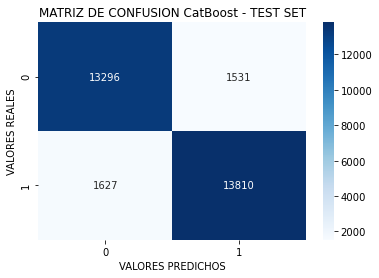

In [44]:
sns.heatmap(confusion_matrix(y_test,best_model.predict(X_test)), annot=True, fmt='4d',cmap='Blues')
plt.xlabel('VALORES PREDICHOS')
plt.ylabel('VALORES REALES')
plt.title('MATRIZ DE CONFUSION CatBoost - TEST SET')
plt.show()


In [45]:
print(classification_report(y_test,best_model.predict(X_test)))

              precision    recall  f1-score   support

          CT       0.89      0.90      0.89     14827
           T       0.90      0.89      0.90     15437

    accuracy                           0.90     30264
   macro avg       0.90      0.90      0.90     30264
weighted avg       0.90      0.90      0.90     30264



In [46]:

roc_auc_score(y_test,best_model.predict(X_test))

ValueError: could not convert string to float: 'T'

**Podemos observar que nuestro modelo esta performando bastante bien, para clasificar las victorias del equipo atacante (Terrorist)**

## FEATURE IMPORTANCE

In [ ]:
feature_names = columnas
feature_importance = best_model[2].feature_importances_


importance = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})

importance_sorted =importance.sort_values('feature_importance', ascending = False).head(10)

importance_sorted

Observamos que la variable que mas influye en la victoria del equipo atacante, es el dinero del que dispone para comprar el equipo defensor, seguida por el dinero que dispone el equipo que ataca. Con lo cual es mas importante que el equipo defensor no pueda comprar bien a que el equipo que ataca pueda comprar bien con una buena economia. **Ésto nos indica que la mejor estrategia es atacar la economia del equipo defensor**

FALTA...

